# 1. GAP - CAM
CAM需要重新训练cnn，用GAP层替换掉FC层，同时也去掉了Flaten层<br />
(1)因为之前训练的网络比较浅，直接替换GAP层后，模型性能大大降低，为了解决这个问题
我们重新训练了模型，使得包含参数的层为7，全部层数(包括无参数层)为11层，最后一个层由sigmoid改成softmax，采用2个神经元用于分类
训练完成后，保存训练好的模型<br />
(2)为了减少重新训练的开销，我们使用迁移学习的方式，固定最后一个卷积层之前的参数，并添加Dense层

## 计算类激活图公式
${S}c = \sum\limits_{k}{w}_{{k}}\sum\limits_{x,y}{f}_{k}(x,y) $

In [1]:
#读取数据
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from keras import Input,layers
from keras import Model
polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
np.random.seed(22)

from keras import Sequential
from keras import layers
from keras.optimizers import Adam
from keras import regularizers
from keras.models import load_model
import os

def get_data(poly_name,file_dir='../data/'):
    '''
    poly_name:是polya的名字
    返回该polya的正负数据与标签
    '''
    file_path_pos = file_dir+poly_name+'.txt'
    file_path_neg = file_dir+'neg'+poly_name+'.txt'
    base2num={
    'A':-2,'T':-1,'C':1,'G':2,
    'a':-2,'t':-1,'c':1,'g':2
    }
    
    base2num={
    'A':np.array([1,0,0,0],dtype='float16'),
    'T':np.array([0,1,0,0],dtype='float16'),
    'C':np.array([0,0,1,0],dtype='float16'),
    'G':np.array([0,0,0,1],dtype='float16'),
    'a':np.array([1,0,0,0],dtype='float16'),
    't':np.array([0,1,0,0],dtype='float16'),
    'c':np.array([0,0,1,0],dtype='float16'),
    'g':np.array([0,0,0,1],dtype='float16')
    }
    
    
    pdata = np.loadtxt(file_path_pos,dtype='str')
    pdata = [seq[:100]+seq[106:] for seq in pdata]
    pdata = [[base2num[base] for base in seq] for seq in pdata]
                   
    ndata = np.loadtxt(file_path_neg,dtype='str')
    ndata = [seq[:100]+seq[106:] for seq in ndata]
    ndata = [[base2num[base] for base in seq] for seq in ndata]
    
    X = np.array(pdata+ndata)
    y = np.append(np.ones(len(pdata)),np.zeros(len(ndata)))
    
    return X,y

def assess(y_true,y_prob,roc=True,pr=False,poly_name=None,line_name=None):
    '''
    pass
    '''
    re={}
    y_true = np.array(y_true,dtype=int)
    y_pred = np.array(y_prob+0.5,dtype=int)
    
    re['accuracy'] = round(metrics.accuracy_score  (y_true,y_pred),3)
    re['precision'] = round(metrics.precision_score(y_true,y_pred),3)
    re['recall'] = round(metrics.recall_score      (y_true,y_pred),3)
    re['f1'] =  round(metrics.f1_score             (y_true,y_pred),3)
    re['auc'] = round(metrics.roc_auc_score        (y_true, y_prob),3)
    
    if (poly_name != None):
        my_label = poly_name+': '+str(re['auc'])
    elif(line_name != None):
        my_label = line_name
    else:
        my_label = 'roc'
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_prob)
    plt.plot(fpr,tpr,label=my_label)
    plt.title('ROC curve')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    
    #precision, recall, thresholds = metrics.precision_recall_curve(y_true,y_prob)
    #plt.plot(precision,recall,label='precison_and_recall')
    plt.legend()
    
    return re

def get_polya_data(polya_name):
    X,y = get_data(polya_name)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=22,)
    X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.25,random_state=22)
    return X_train,X_dev,X_test,y_train,y_dev,y_test

X_train,X_dev,X_test,y_train,y_dev,y_test = [],[],[],[],[],[]
for index,poly in enumerate(polys):
    X_tr,X_de,X_te,y_tr,y_de,y_te = get_polya_data(poly)
    if(index == 0):
        X_train,X_dev,X_test,y_train,y_dev,y_test = X_tr,X_de,X_te,y_tr,y_de,y_te
    else:
        X_train = np.concatenate((X_train,X_tr))
        X_dev   = np.concatenate((X_dev,X_de))
        X_test  = np.concatenate((X_test,X_te))
        y_train = np.append(y_train,y_tr)
        y_dev   = np.append(y_dev,y_de)
        y_test  = np.append(y_test,y_te)
        
# def my_shuffle(*args):
#     for arg in args:
#         np.random.seed(22)
#         np.random.shuffle(arg)
# my_shuffle(X_train,X_dev,X_test,y_train,y_dev,y_test)
# def change_y(y):
#     re = np.zeros((len(y),2))
#     for index,value  in enumerate(y):
#         if(value == 1):
#             re[index] = [1,0]
#         else:
#             re[index] = [0,1]
#     return re
# y_train,y_dev,y_test = change_y(y_train),change_y(y_dev),change_y(y_test)

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 200, 4) (2948, 200, 4) (2948, 200, 4)
Y: (8844,) (2948,) (2948,)


In [3]:
# np.save("../temp_data/X_train.npy",X_train)
# np.save("../temp_data/X_dev.npy",  X_dev)
# np.save("../temp_data/X_test.npy", X_test)

# np.save("../temp_data/y_train.npy",y_train)
# np.save("../temp_data/y_dev.npy",y_dev)
# np.save("../temp_data/y_test.npy",y_test)

# model  = load_model('../saved_model/cnn_conv1d_deep_gap_cam.h5')
X_train = np.load("../temp_data/X_train.npy")
X_dev = np.load("../temp_data/X_dev.npy")
X_test = np.load("../temp_data/X_test.npy")

y_train = np.load("../temp_data/y_train.npy")
y_dev = np.load("../temp_data/y_dev.npy")
y_test = np.load("../temp_data/y_test.npy")

def change_y(y):
    re = np.zeros((len(y),2))
    for index,value  in enumerate(y):
        if(value == 1):
            re[index] = [1,0]
        else:
            re[index] = [0,1]
    return re
y_train,y_dev,y_test = change_y(y_train),change_y(y_dev),change_y(y_test)

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 200, 4) (2948, 200, 4) (2948, 200, 4)
Y: (8844, 2) (2948, 2) (2948, 2)


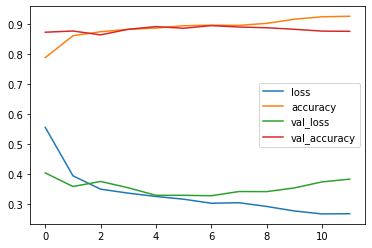

93/93 [==============================] - 0s 3ms/step - loss: 0.4171 - accuracy: 0.8545
[0.4171070158481598, 0.85447758436203]


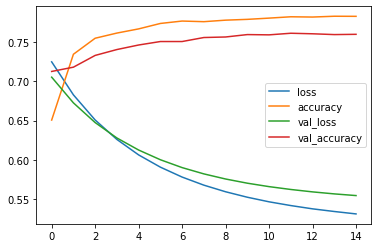

93/93 [==============================] - 0s 4ms/step - loss: 0.5497 - accuracy: 0.7680
[0.5496599078178406, 0.767978310585022]


In [4]:
# 1gap-CAM的模型
#搭建cnn模型
input_tensor = Input(shape = (200,4))
x = layers.Conv1D(64,7,activation='relu',kernel_regularizer=regularizers.l2(0.001))(input_tensor)
x = layers.MaxPool1D(pool_size=2,strides=2, padding='valid')(x)

x = layers.Conv1D(128,7,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.MaxPool1D(pool_size=2,strides=2, padding='valid')(x)

x = layers.Conv1D(128,7,activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.MaxPool1D(pool_size=2,strides=2, padding='valid')(x)

# x = layers.Conv1D(128,7,activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
# x = layers.Conv1D(128,7,activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
# x = layers.MaxPool1D(pool_size=2,strides=2, padding='valid')(x)
x = layers.Flatten()(x)
output_tensor = layers.Dense(2,activation='softmax')(x)

model = Model(input_tensor,output_tensor)
model.compile(optimizer=Adam(lr=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])

hist = model.fit(X_train,y_train,epochs=12,verbose=0,validation_data=(X_dev,y_dev))


import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

print(model.evaluate(X_test,y_test))
model.save('../saved_model/cnn_conv1d_deep_deep.h5')

##################################
#使用迁移学习重新训练模型
#加载保存的模型
base_model = load_model('../saved_model/cnn_conv1d_deep.h5')
# model.summary()
from keras import Input,layers
from keras import Model

model = Sequential()
model.add(base_model.layers[0])
model.add(base_model.layers[1])
model.add(base_model.layers[2])
model.add(base_model.layers[3])
model.add(base_model.layers[4])
model.add(base_model.layers[5])


model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(2,activation='softmax'))

model.layers[0].trainable = False
model.layers[1].trainable = False
model.layers[2].trainable = False
model.layers[3].trainable = False
model.layers[4].trainable = False
model.layers[5].trainable = False

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

hist = model.fit(X_train,y_train,epochs=15,verbose=0,validation_data=(X_dev,y_dev))

import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

print(model.evaluate(X_test,y_test))
model.save('../saved_model/cnn_conv1d_deep_gap_cam.h5')

## 计算类激活图公式
${S}c = \sum\limits_{k}{w}_{{k}}\sum\limits_{x,y}{f}_{k}(x,y) $

In [4]:
from keras import models
from keras.models import load_model
#加载含有GAP层的模型，
model  = load_model('../saved_model/cnn_conv1d_deep_gap_cam.h5')

#获取测试集全部阳性样本
X_True = X_test[y_test[:,0] == 1]
X_False = X_test[y_test[:,0] == 0]

#获取正阳本的权重
layer_gap_weight = model.layers[-1].get_weights()[0] #(128,2)     2个类别

#获取最后一个卷基层的输出
layer_outputs = [ model.layers[-3].output]           #(48,128)    128个chancel
activation_model = models.Model(inputs = model.input,outputs = layer_outputs)

#--------------------
#获取激活正样本的权重
W_k = layer_gap_weight[:,0]#(128,1)



Text(0.5, 1.0, 'X_False:mutiple sequences activation map')

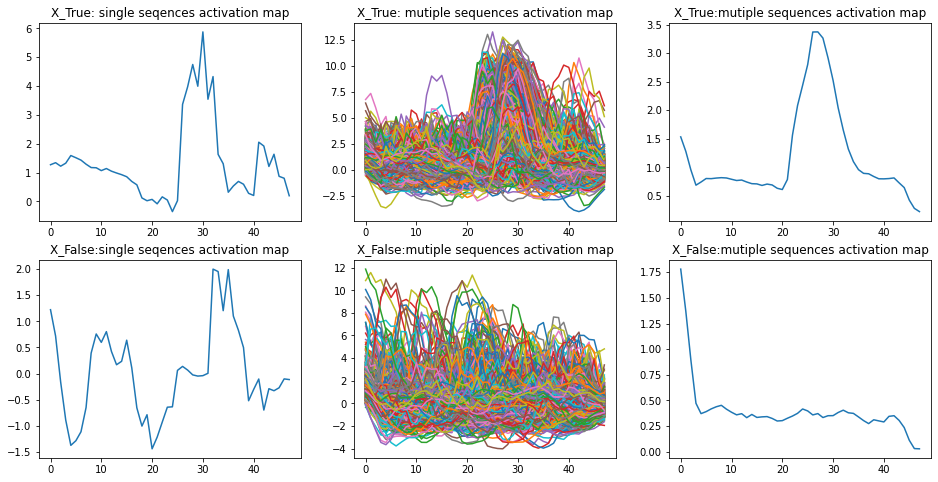

In [5]:
import matplotlib.pyplot as plt
#获取最后一个卷基层的输出,这里是获取测试集全部阳性样本的输出
activations = activation_model.predict(X_True)
activations = activations.reshape(-1,48,128)
fig,ax = plt.subplots(2,3,figsize=(16,8))

#可视化一条序列的激活位置
W_k = W_k
F_k = activations[1]          #(45,128)获取最后一个卷基层的激活
S_c = F_k @ W_k
ax[0][0].plot(S_c)
ax[0][0].set_title("X_True: single seqences activation map")

#可视化测试集阳性序列激活的位置
#
for F_k in activations:
    S_c = F_k @ W_k
    ax[0][1].plot(S_c)
ax[0][1].set_title("X_True: mutiple sequences activation map")

#平均化
S_c = np.zeros(48,)
for F_k in activations:
    S_c = S_c + F_k @ W_k
S_c = S_c / len(activations)
ax[0][2].plot(S_c)
ax[0][2].set_title("X_True:mutiple sequences activation map")

#
activations = activation_model.predict(X_False)
activations = activations.reshape(-1,48,128)


W_k = W_k
F_k = activations[1]          #(45,128)获取最后一个卷基层的激活
S_c = F_k @ W_k
ax[1][0].plot(S_c)
ax[1][0].set_title("X_False:single seqences activation map")

#可视化测试集阳性序列激活的位置
#
for F_k in activations:
    S_c = F_k @ W_k
    ax[1][1].plot(S_c)
ax[1][1].set_title("X_False:mutiple sequences activation map")

#平均化
S_c = np.zeros(48,)
for F_k in activations:
    S_c = S_c + F_k @ W_k
S_c = S_c / len(activations)
ax[1][2].plot(S_c)
ax[1][2].set_title("X_False:mutiple sequences activation map")